In [110]:
# Import libraries
import os
import re
import nltk
import pickle
import urllib
import string
import sqlite3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from bs4 import BeautifulSoup
from argparse import Namespace
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from gensim.models import KeyedVectors
from sklearn.metrics import roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

%matplotlib inline
warnings.filterwarnings("ignore")

color = sns.color_palette()

## Data Information

<h4>Data Set Information:</h4>

<a href="https://archive.ics.uci.edu/ml/datasets/Online+Retail" target="_blank">Online Retail Data Set </a>

<h5>This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based 
    and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.</h5>


<h4>Attribute Information:</h4>

<h5><b>InvoiceNo:</b> Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.<br> 
<b>StockCode:</b> Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
<b>Description:</b> Product (item) name. Nominal. <br>
<b>Quantity:</b> The quantities of each product (item) per transaction. Numeric.<br>
<b>InvoiceDate:</b> Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
<b>UnitPrice:</b> Unit price. Numeric, Product price per unit in sterling. <br>
<b>CustomerID:</b> Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
<b>Country:</b> Country name. Nominal, the name of the country where each customer resides.</h5>

## Load data

In [9]:
data_df = pd.read_excel('retail.xlsx')

## Torture data

In [10]:
print("Shape : ",data_df.shape)

Shape :  (541909, 8)


In [12]:
data_df.sample(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
282569,561651,22889,NUMBER TILE VINTAGE FONT No,1,2011-07-28 15:36:00,4.13,NaN,United Kingdom
66799,541816,22502,PICNIC BASKET WICKER SMALL,4,2011-01-21 15:56:00,5.95,17799.0,United Kingdom
117890,546406,20679,EDWARDIAN PARASOL RED,2,2011-03-11 16:21:00,5.95,NaN,United Kingdom
31682,539007,22080,RIBBON REEL POLKADOTS,1,2010-12-15 13:00:00,1.65,17894.0,United Kingdom


In [13]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


<b>Observation :</b></br>
No of rows : 541909</br>
No of columns : 8</br>
Missing values columns : Description(product name), CustomerID</br>


In [25]:
null_cid = data_df.CustomerID.isnull().sum()
print("Amount of Null customer id : {}".format(null_cid))
print("Percentage of Null customer id : {}%".format(round(null_cid/data_df.shape[0] * 100, 2)))

Amount of Null customer id : 135080
Percentage of Null customer id : 24.93%


In [36]:
data_df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [17]:
#exploring the unique values of each attribute
data_df.nunique()

InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

Total transection done : 25900</br>
Total Items available : 4070</br>
Total unique customer : 4372</br>
Client countries : 38

In [68]:
#get cancelled transactions
cancelled_orders = data_df[data_df['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom


In [51]:
order_cancelled = len(cancelled_orders)
total_order = data_df['InvoiceNo'].nunique()
print("Total no of cancelled order : ", order_cancelled)
print('Percentage of orders canceled: {}/{} ({:.2f}%) '.format(order_cancelled, total_order, order_cancelled/total_order*100))

Total no of cancelled order :  9288
Percentage of orders canceled: 9288/25900 (35.86%) 


## Order per customer

In [58]:
cus_grp = data_df.groupby('CustomerID')['InvoiceNo'].nunique()
cus_grp.head(4)

CustomerID
12346.0    2
12347.0    7
12348.0    4
12349.0    1
Name: InvoiceNo, dtype: int64

In [59]:
cus_grp.describe()

count    4372.000000
mean        5.075480
std         9.338754
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       248.000000
Name: InvoiceNo, dtype: float64

Average number of orders per customer : 5

In [83]:
#average number of unique items per order
groupby_invoice = pd.DataFrame(data_df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns=['product count']
groupby_invoice.head()

,product count
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [84]:
groupby_invoice.describe()

,product count
count,25900.000000
mean,20.510618
std,42.500488
min,1.000000
25%,2.000000
50%,10.000000
75%,23.000000
max,1110.000000


In [63]:
data_df.groupby(['InvoiceNo','CustomerID'])['StockCode'].nunique().describe()

count    22190.000000
mean        17.876566
std         22.872614
min          1.000000
25%          3.000000
50%         12.000000
75%         24.000000
max        541.000000
Name: StockCode, dtype: float64

In [67]:
temp_df =data_df.groupby(['InvoiceNo','CustomerID'],as_index=False)['InvoiceDate'].count()
transaction_df = temp_df.rename(columns = {'InvoiceDate':'Number of products'})
transaction_df.sample(5)

,InvoiceNo,CustomerID,Number of products
10432,562591,12748.0,2
17652,579513,12971.0,3
8762,558555,15578.0,13
17313,578708,15737.0,2
7043,554139,14911.0,52


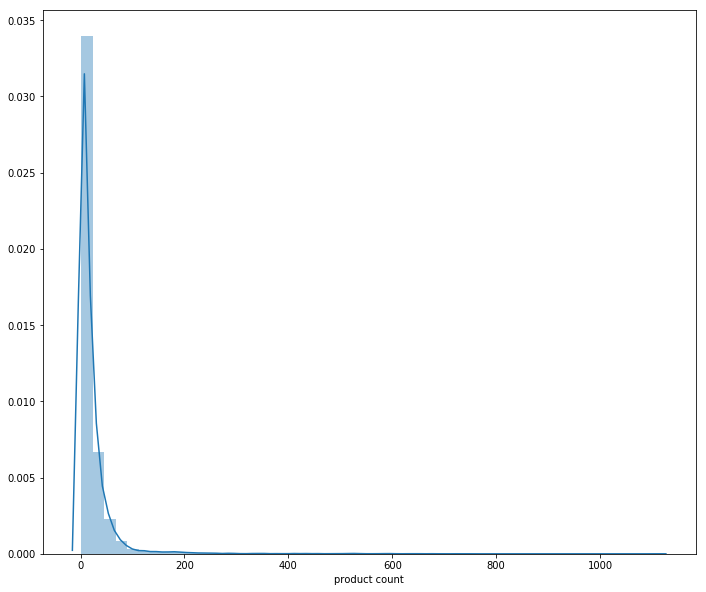

In [86]:
#Visualize the variable productsNumber distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 10)
sns.distplot(groupby_invoice['product count'],ax=ax)
plt.show()

## Customers by country

In [89]:
data_df['totalCost'] = data_df['Quantity'] * data_df['UnitPrice']
data_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,totalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34


 ## Total revenue per country

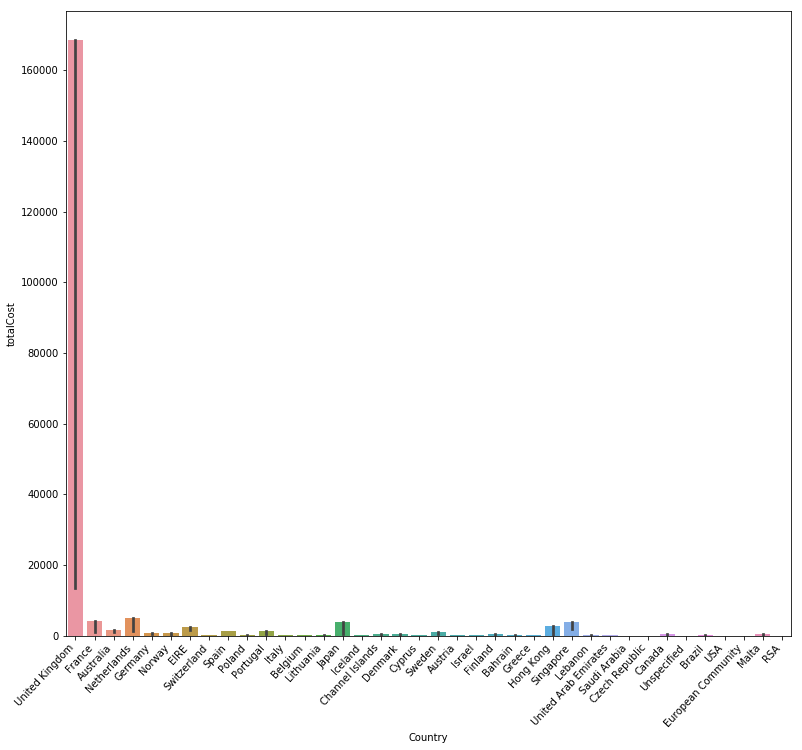

In [90]:
fig, ax = plt.subplots()
fig.set_size_inches(13, 11.5)
ax=sns.barplot(x='Country', y='totalCost',data=data_df,estimator=max,ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=47, ha="right")
plt.show()

In [96]:
data_df.groupby('Country').sum().sort_values(by='totalCost', ascending=False)

,Quantity,UnitPrice,CustomerID,total_cost,totalCost
Country,,,,,
United Kingdom,4263829,2.245715e+06,5.626433e+09,8.187806e+06,8.187806e+06
Netherlands,200128,6.492550e+03,3.419054e+07,2.846615e+05,2.846615e+05
EIRE,142637,4.844719e+04,1.103917e+08,2.632768e+05,2.632768e+05
Germany,117448,3.766600e+04,1.200751e+08,2.216982e+05,2.216982e+05
France,110480,4.303199e+04,1.076489e+08,1.974039e+05,1.974039e+05
Australia,83653,4.054750e+03,1.569300e+07,1.370773e+05,1.370773e+05
Switzerland,30325,6.813690e+03,2.377592e+07,5.638535e+04,5.638535e+04
Spain,26824,1.263345e+04,3.268929e+07,5.477458e+04,5.477458e+04
Belgium,23152,7.540130e+03,2.571829e+07,4.091096e+04,4.091096e+04


In [98]:
# total customer in UK
data_df[data_df['Country']=='United Kingdom']['CustomerID'].nunique()

3950

In [99]:
data_uk = data_df[data_df['Country']=='United Kingdom']
data_uk.describe()

,Quantity,UnitPrice,CustomerID,total_cost,totalCost
count,495478.000000,495478.000000,361878.000000,495478.000000,495478.000000
mean,8.605486,4.532422,15547.871368,16.525065,16.525065
std,227.588756,99.315438,1594.402590,394.839116,394.839116
min,-80995.000000,-11062.060000,12346.000000,-168469.600000,-168469.600000
25%,1.000000,1.250000,14194.000000,3.290000,3.290000
50%,3.000000,2.100000,15514.000000,8.290000,8.290000
75%,10.000000,4.130000,16931.000000,16.630000,16.630000
max,80995.000000,38970.000000,18287.000000,168469.600000,168469.600000


In [101]:
print("Number of transactions: ", data_uk['InvoiceNo'].nunique())
print("Number of products bought: ",data_uk['StockCode'].nunique())
print("Number of customers:", data_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(data_uk['CustomerID'].isnull().sum() * 100 / len(data_uk),2),"%" )
print('Number of countries: ',data_uk['Country'].nunique())

Number of transactions:  23494
Number of products bought:  4065
Number of customers: 3950
Percentage of customers NA:  26.96 %
Number of countries:  1


## Explore quantity

### Most bought product in UK

In [102]:
groupedProduct = data_uk.groupby('StockCode',as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
groupedProduct.head(10)

,StockCode,Quantity
1068,22197,52928
2620,84077,48326
3655,85099B,43167
3666,85123A,36706
2733,84879,33519
1451,22616,25307
375,21212,24702
1049,22178,23242
39,17003,22801
887,21977,20288


In [103]:
invoice_quantity= data_uk.groupby('InvoiceNo', as_index=False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
invoice_quantity.head()

,InvoiceNo,Quantity
20090,581483,80995
2136,541431,74215
17136,574941,14149
17765,576365,13956
13770,567423,12572


##### Lets do <b>Market Basket Analysis</b> to understand whether any relationship is there between products. Like when when one is bught another is also bought.

In [111]:
data_df.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,total_cost,totalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,20.34


In [112]:
#remove additional spaces
data_df['Description'] = data_df['Description'].str.strip()
#remove NA values
data_df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
#remove cancelled orders
data_df['InvoiceNo'] = data_df['InvoiceNo'].astype('str')
clean_data_df = data_df[~data_df['InvoiceNo'].str.contains('C')]

In [115]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

def create_basket(country_filter):
    basket = (clean_data_df[clean_data_df['Country'] == country_filter]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
    return basket

In [116]:
country_filter = "France"
basket_french = create_basket("France")
basket_sets = basket_french.applymap(encode_units)
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [117]:
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)

In [118]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(LUNCH BAG SPACEBOY DESIGN),(LUNCH BAG RED RETROSPOT),0.119898,0.153061,0.066327,0.553191,3.614184,0.047975,1.895530
1,(LUNCH BAG RED RETROSPOT),(LUNCH BAG SPACEBOY DESIGN),0.153061,0.119898,0.066327,0.433333,3.614184,0.047975,1.553121
2,(PLASTERS IN TIN WOODLAND ANIMALS),(RED TOADSTOOL LED NIGHT LIGHT),0.170918,0.181122,0.053571,0.313433,1.730502,0.022614,1.192713
3,(RED TOADSTOOL LED NIGHT LIGHT),(PLASTERS IN TIN WOODLAND ANIMALS),0.181122,0.170918,0.053571,0.295775,1.730502,0.022614,1.177296
4,"(PLASTERS IN TIN SPACEBOY, PLASTERS IN TIN CIR...",(PLASTERS IN TIN WOODLAND ANIMALS),0.089286,0.170918,0.068878,0.771429,4.513433,0.053617,3.627232


## Cancled order analysis

In [71]:
cancelled_orders = data_df[data_df['InvoiceNo'].astype(str).str.contains('C')]
order_cancelled = len(cancelled_orders)
total_order = data_df['InvoiceNo'].nunique()
print("Total no of cancelled order : ", order_cancelled)
print('Percentage of orders canceled: {}/{} ({:.2f}%) '.format(order_cancelled, total_order, order_cancelled/total_order*100))

Total no of cancelled order :  9288
Percentage of orders canceled: 9288/25900 (35.86%) 


In [72]:
cancelled_orders.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548.0,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom


In [80]:
cancelled_orders_country = cancelled_orders.groupby('Country')
for cnt, cnt_grp in cancelled_orders_country:
    print(cnt, '------', round(cnt_grp['InvoiceNo'].count()/data_df.shape[0]*100, 4),'%')
    


Australia ------ 0.0137 %
Austria ------ 0.0006 %
Bahrain ------ 0.0002 %
Belgium ------ 0.007 %
Channel Islands ------ 0.0018 %
Cyprus ------ 0.0015 %
Czech Republic ------ 0.0009 %
Denmark ------ 0.0017 %
EIRE ------ 0.0557 %
European Community ------ 0.0002 %
Finland ------ 0.0018 %
France ------ 0.0275 %
Germany ------ 0.0836 %
Greece ------ 0.0002 %
Hong Kong ------ 0.0007 %
Israel ------ 0.0004 %
Italy ------ 0.0083 %
Japan ------ 0.0068 %
Malta ------ 0.0028 %
Netherlands ------ 0.0015 %
Norway ------ 0.0026 %
Poland ------ 0.002 %
Portugal ------ 0.0033 %
Saudi Arabia ------ 0.0002 %
Singapore ------ 0.0013 %
Spain ------ 0.0089 %
Sweden ------ 0.002 %
Switzerland ------ 0.0065 %
USA ------ 0.0207 %
United Kingdom ------ 1.4497 %
